In this notebook, we will bias-adjust projected CMIP6 data using the downscaled ERA5 data for Alaska and compute projected hardiness zone maps!

In [1]:
import warnings
import logging
import numpy as np
import xarray as xr
from pathlib import Path
from xclim import indices, sdba
from xclim.core.units import convert_units_to
from xclim.sdba.detrending import LoessDetrend
from xarray.coding.calendar_ops import convert_calendar


import xesmf as xe
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray
from pyproj import CRS, Transformer, Proj
from dask.distributed import LocalCluster, Client


# path to reference ERA5 data
# this is ERA5 data that has been regridded to EPSG:3338 via bilinear interpolation using defaults with rioxarray
era5_fp = Path("/beegfs/CMIP6/kmredilla/downscaling/era5_fine.nc")

cmip6_dir = Path("/beegfs/CMIP6/kmredilla/cmip6_4km_3338/regrid")

In [3]:
# module


# add lat lon coords to ref ERA5 data
def add_lat_lon_coords(era5_ds):
    """ERA5 does not have lat lon coords. This function adds lat lon coords to the ERA5 data for regridding CMIP6-->target with xESMF."""
    import numpy as np
    from pyproj import Transformer

    transformer_3338_to_4326 = Transformer.from_crs(3338, 4326)
    xx, yy = np.meshgrid(era5_ds["x"].values, era5_ds["y"].values)
    lat, lon = transformer_3338_to_4326.transform(xx, yy)
    era5_ds = era5_ds.assign_coords(lon=(("y", "x"), lon), lat=(("y", "x"), lat))

    return era5_ds


def reproject_wrf_3338(geo_ds, da):
    """reproject a WRF dataarray to EPSG:3338"""
    wrf_proj = "+proj=stere +units=m +a=6370000.0 +b=6370000.0 +lat_0=90.0 +lon_0=-152 +lat_ts=64 +nadgrids=@null"

    # WGS84 projection
    wgs_proj = Proj(proj="latlong", datum="WGS84")
    wgs_to_wrf_transformer = Transformer.from_proj(wgs_proj, wrf_proj)

    # this is where we plug in the center longitude of the domain to get the center x, y in projected space
    e, n = wgs_to_wrf_transformer.transform(
        geo_ds.attrs["CEN_LON"], geo_ds.attrs["TRUELAT1"]
    )

    # now compute the rest of the grid based on x/y dimension lengths and grid spacing
    dx = dy = 4000
    nx = da.west_east.shape[0]
    ny = da.south_north.shape[0]
    x0 = -(nx - 1) / 2.0 * dx + e
    y0 = -(ny - 1) / 2.0 * dy + n
    # 2d grid coordinate values
    x = np.arange(nx) * dx + x0
    y = np.arange(ny) * dy + y0

    wrf_crs = CRS.from_proj4(wrf_proj)
    da = (
        da.rename({"south_north": "y", "west_east": "x"})
        .assign_coords({"y": ("y", y), "x": ("x", x)})
        .rio.set_spatial_dims("x", "y")
        .to_dataset()
        .rio.write_crs(wrf_crs)
    )

    da_3338 = da.rio.reproject("EPSG:3338")

    return da_3338

Open connection to ERA5 WRF dataset that has been regridded to EPSG:3338. 

The regridding for this dataset was done using a function like that found above, relying on `rioxarray` to choose a sane default target grid. 

In [4]:
era5_ds = xr.open_dataset(era5_fp)
# era5_ds = add_lat_lon_coords(era5_ds)
era5_ds["t2min"].attrs["units"] = "K"

To prep the daily ERA5 data for monthly bias adjustment, we to resample it to a monthly frequency and also convert the calendar to a no-leap version to match that of the regridded CMIP6 data:

In [5]:
ref = convert_calendar(
    convert_units_to(era5_ds["t2min"].resample(time="1ME").min(), "degC"), "noleap"
)

Okay, we also need all of the CMIP6 data on this target grid, even though it is natively a much, much coarser resolution. We will then perform a bias adjustment. 

Because hardiness zones are based on annual extreme minimum temperatures, we should be able to use monthly minimum temperature data. So we will choose the models in our ensemble that have minimum temperature data available for the historical experiment and at least one future SSP. 

There are 9 models in our 12-model ensemble that have historical monthly minimum temperature data available:
* CNRM-CM6-1-HR
* EC-Earth3-Veg
* GFDL-ESM4
* HadGEM3-GC31-LL
* HadGEM3-GC31-MM
* KACE-1-0-G
* MIROC6
* MPI-ESM1-2-HR
* MRI-ESM2-0

Although two additional models do have daily minimum temperature data that can be resampled to monthly:
* NorESM2-MM
* TaiESM1

In [6]:
# all MONTHLY files have date strings of format "YYYYMM-YYYYMM". Use this info to choose the files that cover a given time period
def get_files_for_period(files, start_date, end_date):
    def parse_date(f, which):
        which_lu = {"start": 0, "end": 1}
        return int(f.name.split(".")[0].split("_")[-1].split("-")[which_lu[which]])

    fps = [
        f
        for f in files
        if not (
            (parse_date(f, "end") < start_date) or (parse_date(f, "start") > end_date)
        )
    ]
    return sorted(fps)


def get_sim_fps(cmip6_dir, model, scenario, freq, var_id, start_date, end_date):
    all_fps = list(cmip6_dir.glob(f"{model}/{scenario}/{freq}/{var_id}/*.nc"))
    return get_files_for_period(all_fps, start_date, end_date)

In [14]:
hist_start = 199501
hist_end = 201412
model = "GFDL-ESM4"
hist_fps = get_sim_fps(
    cmip6_dir, model, "historical", "Amon", "tasmin", hist_start, hist_end
)

In [15]:
sim_start = 201501
sim_end = 209912
sim_fps = get_sim_fps(cmip6_dir, model, "ssp585", "Amon", "tasmin", sim_start, sim_end)

In [9]:
cluster = LocalCluster(n_workers=16, threads_per_worker=1)

client = Client(cluster)

In [10]:
hist_ds = xr.open_mfdataset(hist_fps)
hist = hist_ds["tasmin"].chunk({"time": -1, "x": 20, "y": 20})

sim_ds = xr.open_mfdataset(sim_fps)
sim = sim_ds["tasmin"].chunk({"time": -1, "x": 20, "y": 20})

In [19]:
# we are getting two kinds of warnings with these bias adjustment computations.
# the first is a warning for trying to interpolate over parts of the grid that have nodata.
# the second is for large graph sizes. I could not get warnings silced ussing the context manager,
# so this is just a blanket filter that seems to work.
warnings.simplefilter("ignore")

In [16]:
kind = "+"
train_kwargs = dict(
    ref=ref,
    hist=hist,
    nquantiles=50,
    group="time.month",
    # window=31,
    kind=kind,
)

dqm = sdba.DetrendedQuantileMapping.train(**train_kwargs)

In [21]:
# Create the detrending object
det = LoessDetrend(group="time.month", d=0, niter=1, f=0.2, weights="tricube")

hist_adj = (
    (
        dqm.adjust(hist, extrapolation="constant", interp="nearest", detrend=det)
        # in testing, adjusted outputs are oriented lat, lon, time for some reason
    )
    .rename("tasmin")
    .assign_coords({"model": model, "scenario": "historical"})
    .expand_dims(["model", "scenario"])
)

In [34]:
def train_hist_adj(
    ref,
    cmip6_dir,
    model,
    det,
):
    hist_fps = get_sim_fps(
        cmip6_dir,
        model,
        "historical",
        "Amon",
        "tasmin",
        int(ref.time.values[0].strftime("%Y%m")),
        int(ref.time.values[-1].strftime("%Y%m")),
    )
    if len(sim_fps) == 0:
        print(f"No historical files found for {model}")
        return None, None
    hist_ds = xr.open_mfdataset(hist_fps)
    hist = hist_ds["tasmin"].chunk({"time": -1, "x": 20, "y": 20})

    kind = "+"
    train_kwargs = dict(
        ref=ref,
        hist=hist,
        nquantiles=50,
        group="time.dayofyear",
        window=31,
        kind=kind,
    )

    dqm = sdba.DetrendedQuantileMapping.train(**train_kwargs)

    hist_adj = (
        (
            dqm.adjust(hist, extrapolation="constant", interp="nearest", detrend=det)
            # in testing, adjusted outputs are oriented lat, lon, time for some reason
        )
        .rename("tasmin")
        .assign_coords({"model": model, "scenario": "historical"})
        .expand_dims(["model", "scenario"])
    )

    return dqm.load(), hist_adj.load()


def adjust_sim(dqm, cmip6_dir, model, scenario, det):
    sim_start = 201501
    sim_end = 209912
    sim_fps = get_sim_fps(
        cmip6_dir,
        model,
        scenario,
        "Amon",
        "tasmin",
        sim_start,
        sim_end,
    )

    if len(sim_fps) == 0:
        print(f"No scenario files found for {model} {scenario}")
        return None, None
    sim_ds = xr.open_mfdataset(sim_fps)
    sim = sim_ds["tasmin"].chunk({"time": -1, "x": 20, "y": 20})

    sim_adj = (
        (dqm.adjust(sim, extrapolation="constant", interp="nearest", detrend=det))
        .rename("tasmin")
        .assign_coords({"model": model, "scenario": scenario})
        .expand_dims(["model", "scenario"])
    )

    return sim.load(), sim_adj.load()

In [ ]:
sim, sim_adj = adjust_sim(dqm, cmip6_dir, model, "ssp585", det)

In [ ]:
models = [
    "CNRM-CM6-1-HR",
    "EC-Earth3-Veg",
    "GFDL-ESM4",
    "HadGEM3-GC31-LL",
    "HadGEM3-GC31-MM",
    "KACE-1-0-G",
    "MIROC6",
    "MPI-ESM1-2-HR",
    "MRI-ESM2-0",
]

In [ ]:
dqm_lu = {}
sim_das = []
adj_das = []
for model in models:
    dqm, hist_adj = train_hist_adj(
        ref,
        cmip6_dir,
        model,
        det,
    )
    dqm_lu[model] = dqm
    adj_das.append(hist_adj)
    print(f"Finished {model} historical")

    for scenario in ["ssp245", "ssp370", "ssp585"]:
        sim, adj = adjust_sim(dqm, cmip6_dir, model, scenario, det)
        # or just write to output?
        adj_das.append(adj)
        sim_das.append(sim)
        print(f"Finished {model} {scenario}")

[PosixPath('/beegfs/CMIP6/kmredilla/cmip6_4km_3338/regrid/GFDL-ESM4/ssp585/Amon/tasmin/tasmin_Amon_GFDL-ESM4_ssp585_regrid_201501-201512.nc'),
 PosixPath('/beegfs/CMIP6/kmredilla/cmip6_4km_3338/regrid/GFDL-ESM4/ssp585/Amon/tasmin/tasmin_Amon_GFDL-ESM4_ssp585_regrid_201601-201612.nc'),
 PosixPath('/beegfs/CMIP6/kmredilla/cmip6_4km_3338/regrid/GFDL-ESM4/ssp585/Amon/tasmin/tasmin_Amon_GFDL-ESM4_ssp585_regrid_201701-201712.nc'),
 PosixPath('/beegfs/CMIP6/kmredilla/cmip6_4km_3338/regrid/GFDL-ESM4/ssp585/Amon/tasmin/tasmin_Amon_GFDL-ESM4_ssp585_regrid_201801-201812.nc'),
 PosixPath('/beegfs/CMIP6/kmredilla/cmip6_4km_3338/regrid/GFDL-ESM4/ssp585/Amon/tasmin/tasmin_Amon_GFDL-ESM4_ssp585_regrid_201901-201912.nc'),
 PosixPath('/beegfs/CMIP6/kmredilla/cmip6_4km_3338/regrid/GFDL-ESM4/ssp585/Amon/tasmin/tasmin_Amon_GFDL-ESM4_ssp585_regrid_202001-202012.nc'),
 PosixPath('/beegfs/CMIP6/kmredilla/cmip6_4km_3338/regrid/GFDL-ESM4/ssp585/Amon/tasmin/tasmin_Amon_GFDL-ESM4_ssp585_regrid_202101-202112.nc'),

In [ ]:
model = "GFDL-ESM4"
scenario = "historical"
freq = "Amon"
var_id = "tasmin"

all_fps = list(cmip6_dir.glob(f"{model}/{scenario}/{freq}/{var_id}/*.nc"))

In [43]:
def parse_date(f, which):
    which_lu = {"start": 0, "end": 1}
    return int(f.name.split(".")[0].split("_")[-1].split("-")[which_lu[which]])


files = all_fps
start_date, end_date = 199412, 201412
fps = [
    f
    for f in files
    if not ((parse_date(f, "end") < start_date) or (parse_date(f, "start") > end_date))
]

In [42]:
parse_date(all_fps[1], "end") < start_date

True

In [39]:
parse_date(all_fps[0], "start") < start_date

False

In [5]:
hist_ds = xr.open_dataset(
    "/beegfs/CMIP6/kmredilla/cmip6_4km_3338/regrid/MRI-ESM2-0/historical/Amon/tasmin/tasmin_Amon_MRI-ESM2-0_historical_regrid_201201-201212.nc"
)

In [33]:
ref = era5_ds["t2min"].resample(time="ME").min()
ref = convert_units_to(ref, "degC")

In [22]:
from xclim import indices

In [30]:
test.attrs["units"] = "K"

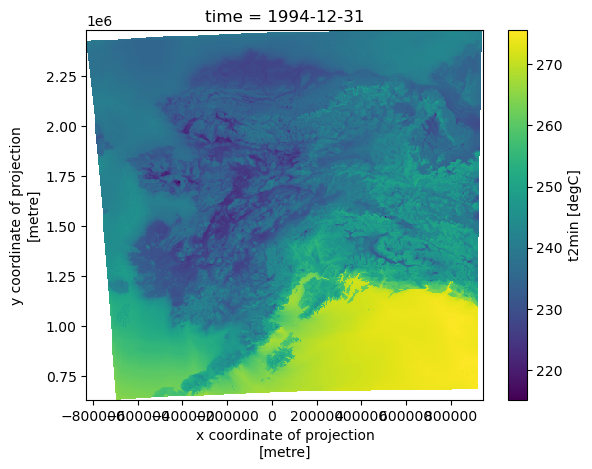

In [29]:
test.isel(time=0).plot()

In [40]:
test = indices.hardiness_zones(ref, window=22)

Here we will regrid the landmask to the same target grid:

In [65]:
landmask = geo_ds["LANDMASK"]

In [71]:
landmask

<xarray.DataArray 'LANDMASK' (Time: 1, south_north: 204, west_east: 264)> Size: 215kB
[53856 values with dtype=float32]
Dimensions without coordinates: Time, south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    units:        none
    description:  Landmask : 1=land, 0=water
    stagger:      M
    sr_x:         1
    sr_y:         1

In [ ]:
geo_ds = xr.open_dataset("/beegfs/CMIP6/wrf_era5/geo_em.d02.nc")

In [81]:
test = reproject_wrf_3338(geo_ds, geo_ds["LANDMASK"].sel(Time=0))

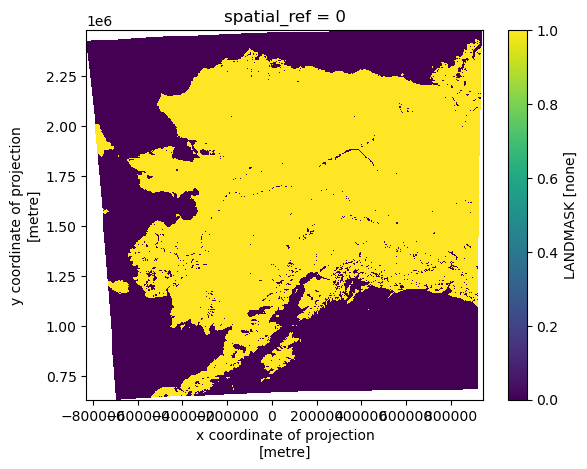

In [84]:
test["LANDMASK"].plot()

In [ ]:
hist_dir = Path(
    "/beegfs/CMIP6/kmredilla/cmip6_regridding/regrid/GFDL-ESM4/historical/day/tasmax"
)
hist_fps = []
for year in range(1995, 2015):
    hist_fps.extend(sorted(hist_dir.glob(f"*{year}0101*.nc")))

hist_ds = xr.open_mfdataset(hist_fps).transpose("time", "lat", "lon")

sel_di = dict(lon=slice(-176, -129), lat=slice(72, 55.5))
hist_da = hist_ds["tasmax"].sel(sel_di)

# Also using this cell to produce a bilinear resampled version of the historical data on target grid
interp_method = "bilinear"
# interp_method = "nearest_d2s"
# interp_method = "nearest_s2d"
# interp_method = "patch"

sim_regridder = xe.Regridder(hist_da, era5_fine_ds, interp_method, unmapped_to_nan=True)
hist_fine = sim_regridder(hist_da, keep_attrs=True)

hist_fine_dir = downscaling_dir.joinpath(f"gfdl_historical_tasmax_fine_{interp_method}")
hist_fine_dir.mkdir(exist_ok=True)
for year in np.unique(hist_fine.time.dt.year):
    tmp_fp = hist_fine_dir.joinpath(
        f"gfdl_historical_tasmax_fine_{interp_method}_{year}.nc"
    )
    hist_fine.sel(time=str(year)).drop_vars("height").to_dataset().to_netcdf(tmp_fp)
    print(f"{year} done", end=", ")